# DDIM：去噪扩散隐式模型学习笔记

## 本文结构一览
本文的前半部分提出了非马尔可夫假设，以此为基础，套用DDPM的模型，并采用了与DDPM相同的损失函数。在第四部分，本文基于非马尔可夫性质提出了跳步采样的方法，并与ode相结合。

## 1.背景：DDPM 的局限性
DDPM 基于马尔可夫过程，在进行反向过程时，必须一步一步地进行采样，这会导致采样时间过长，模型训练速度过慢。因此本文的工作想要达成的是：借用 DDPM 的数学基础，但舍弃马尔可夫性质，从而实现一种跳步采样。

首先注意到本文的符号系统：
$$
\alpha_t ~in~DDIM~:=~ \bar{\alpha}_t~in~DDPM
$$
此外，本文的前向过程中没有像 DDPM 那样的超参数 $\beta$，而是引入推断分布族 $q_{\sigma}$ with $\sigma \in \mathbb{R^T}$ 且 $\sigma \geq 0$

## 2.前向：马尔可夫性 $\rightarrow$ 条件独立性

在前向过程中，我们舍弃了马尔可夫性，在这种情况下，我们认为 $x_t$ 是由且只由 $x_{t-1}$ 和 $x_0$ 共同决定的。因此可以推出本文的公式(6)。

这一部分的公式大量来源于DDPM，只需要替换符号系统就可以化得[1]：
$$
q(\mathbf{x}_t|\mathbf{x}_0)=\mathcal{N}(\mathbf{x}_t;\sqrt{\bar{\alpha}_t}\mathbf{x}_0,(1-\bar{\alpha}_t)\mathbf{I})
$$
$$
\downarrow
$$
$$
\begin{aligned}q_\sigma(\boldsymbol{x}_T|\boldsymbol{x}_0)=\mathcal{N}(\sqrt{\alpha_T}\boldsymbol{x}_0,(1-\alpha_T)\boldsymbol{I})\end{aligned}
$$
可以看到和 DDPM 一样，前向过程的目的也是生成一个高斯分布的纯噪声。

在DDPM的变分推断过程中，利用到了如下的后验概率[2]：
$$\begin{aligned}q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0})&=\mathcal{N}(\mathbf{x}_{t-1};\tilde{\boldsymbol{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0}),\beta_{t}\mathbf{I}),\\\mathrm{where}\quad\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t,\mathbf{x}_0)&:=\frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}\mathbf{x}_0+\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\mathbf{x}_t\quad\mathrm{and}\quad\tilde{\beta}_t:=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t\end{aligned}$$
$$
\downarrow (替换均值函数符号)
$$
$$q_\sigma(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t,\boldsymbol{x}_0)=\mathcal{N}\left(\sqrt{\alpha_{t-1}}\boldsymbol{x}_0+\sqrt{1-\alpha_{t-1}-\sigma_t^2}\cdot\frac{\boldsymbol{x}_t-\sqrt{\alpha_t}\boldsymbol{x}_0}{\sqrt{1-\alpha_t}},\sigma_t^2\boldsymbol{I}\right)$$

注意这里方差项直接舍弃了 $\beta$ 项，直接采用向量 $\sigma$。

## 3.反向：先预测 $x_0$ 再预测前一步
因为我们这里不满足马尔可夫性质，所以 $p(x_{t-1} \mid x_t)$ 这种写法是不能表示前后步关系的，根据条件假设，写成 $p(x_{t-1} \mid x_t, x_0)$ 才行。因此本部分需要利用这种形式进行反向去噪。根据重参数化公式：
$$\boldsymbol{x}_t=\sqrt{\alpha_t}\boldsymbol{x}_0+\sqrt{1-\alpha_t}\epsilon,\quad\mathrm{where}\quad\epsilon\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{I})$$

因此，我们的思路是 
- <span style="color:lightblue">重写上式[3]：</span> $\hat{x_0^{(t)}} = f_{\theta}(x_t) = \frac{x_t - \sqrt{1-\alpha_t}\epsilon_{\theta}}{\sqrt{\alpha_t}}$
- <span style="color:lightblue">然后采用 2[2] 中的公式，预测 </span>$x_{t-1}$
- <span style="color:lightblue">把上面的结论代入，就可以得到原文公式(10)</span>

最后，优化函数被证明与 DDPM 中的一致：都采用噪声的 MSE

[3]：写成这样说明我们要从带噪样本中预测噪声并去除，$\epsilon_{\theta}$ 就是一个网络，接受时间步参数。

## 4.加速：舍弃马尔可夫性质后的视角

以下参考 [知乎专栏](https://zhuanlan.zhihu.com/p/627616358)

问题1：为什么DDPM不能跳步
- 因为整个DDPM后期的公式都严格依赖于马尔可夫性，因此跳步就会导致模型不成立。
  
问题2：为什么DDIM可以跳步
- 这是因为我们每次要反向预测前一步的时候，都是先预测 $x_0$ 再根据 $x_0$ 生成 $x_{t-1}$ ，因此我们可以跳步：直接用 $x_0$ 生成 $x_k$。（因为 $\boldsymbol{x}_t=\sqrt{\alpha_t}\boldsymbol{x}_0+\sqrt{1-\alpha_t}\epsilon$ 成立）

## 5.神经微分方程与 DDIM

### 欧拉法
欧拉法是一种求ode数值解的方法，其基本思想是通过已知的初值条件，利用其在这一点的导数来估计该点附近函数的变化率，从而迭代到下一个点。

即对于ode:
$$y' = f(y,t)$$
有：
$$y(t_1) = y(t_0+\Delta t) = y(t_0) + \Delta t \cdot f(y_0,t_0)$$

下面展示了步长为20的欧拉法数值解和解析解的对比：

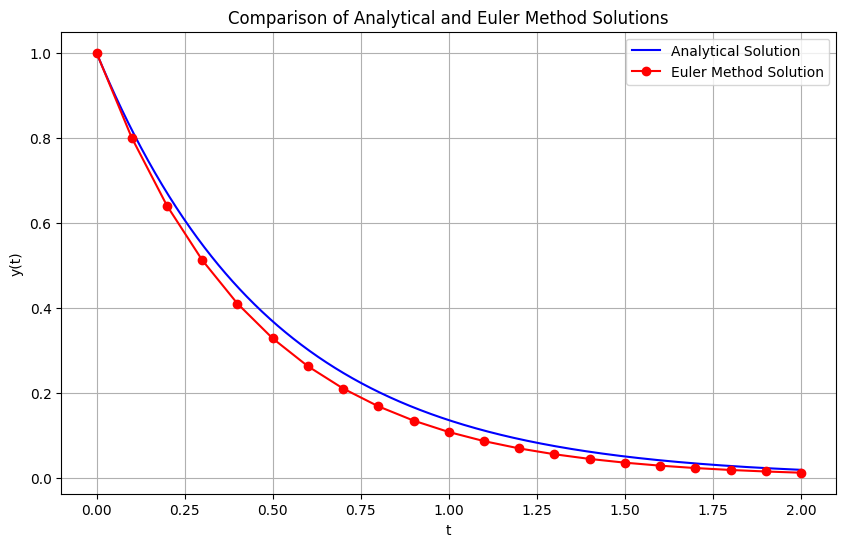

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常微分方程的右侧函数
def ode_function(t, y):
    return -2 * y

# 解析解函数
def analytical_solution(t):
    return np.exp(-2 * t)

# 欧拉法求解函数
def euler_method(ode_func, t0, y0, t_end, num_steps):
    dt = (t_end - t0) / num_steps
    t_values = np.linspace(t0, t_end, num_steps + 1)
    y_values = np.zeros(num_steps + 1)
    y_values[0] = y0

    for i in range(num_steps):
        y_values[i + 1] = y_values[i] + ode_func(t_values[i], y_values[i]) * dt

    return t_values, y_values

# 初始条件和参数设置
t0 = 0
y0 = 1
t_end = 2
num_steps = 20

# 使用欧拉法求解
t_euler, y_euler = euler_method(ode_function, t0, y0, t_end, num_steps)

# 计算解析解
t_analytical = np.linspace(t0, t_end, 1000)
y_analytical = analytical_solution(t_analytical)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(t_analytical, y_analytical, label='Analytical Solution', color='blue')
plt.plot(t_euler, y_euler, 'o-', label='Euler Method Solution', color='red')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Comparison of Analytical and Euler Method Solutions')
plt.legend()
plt.grid(True)
plt.show()

### 重参数化
原文建模中采用的公式(12)为：
$$\boldsymbol{x}_{t-1}=\sqrt{\alpha_{t-1}}\underbrace{\left(\frac{\boldsymbol{x}_t-\sqrt{1-\alpha_t}\epsilon_\theta^{(t)}(\boldsymbol{x}_t)}{\sqrt{\alpha_t}}\right)}_{\text{“predicted }\boldsymbol{x}_0\mathrm{”}}+\underbrace{\sqrt{1-\alpha_{t-1}-\sigma_t^2}\cdot\epsilon_\theta^{(t)}(\boldsymbol{x}_t)}_{\text{“direction pointing to }\boldsymbol{x}_t\mathrm{”}}+\underbrace{\sigma_t\epsilon_t}_{\text{random noise}}$$

如果令 $\sigma_t = \boldsymbol{0}, t - 1 \rightarrow t - \Delta t$：
$$\frac{\boldsymbol{x}_{t-\Delta t}}{\sqrt{\alpha_{t-\Delta t}}}=\frac{\boldsymbol{x}_t}{\sqrt{\alpha_t}}+\left(\sqrt{\frac{1-\alpha_{t-\Delta t}}{\alpha_t-\Delta t}}-\sqrt{\frac{1-\alpha_t}{\alpha_t}}\right)\epsilon_\theta^{(t)}(\boldsymbol{x}_t)$$
因此可以化为一个ode，可以采用神经微分方程的方法实现DDIM。